# グラフ分割問題

まず、使用する主要なライブラリをインストールし、インポートしましょう。

In [1]:
# !pip install qamomile[qiskit, quri_parts]

In [2]:
from collections import defaultdict
import random
from typing import Sequence

import jijmodeling as jm
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import ommx
import qiskit.primitives as qk_pr
from quri_parts.core.state import quantum_state, apply_circuit
from quri_parts.qulacs.estimator import create_qulacs_vector_parametric_estimator
from quri_parts.qulacs.sampler import create_qulacs_vector_sampler
from scipy.optimize import minimize

import qamomile.core as qm
from qamomile.core.circuit.drawer import plot_quantum_circuit
import qamomile.qiskit as qm_qk
from qamomile.quri_parts import QuriPartsTranspiler

## グラフ分割問題とは

グラフ分割問題とは、頂点数が \( V \) のグラフ \( G \) を、**エッジの切断数が最小となるように2つの部分に分割する問題**です。  
例えば、以下のような6頂点のグラフを考えてみましょう。

![init_graph](graph_partition_fig/graph_init.png)

これを3頂点ずつの2つのグループに分割すると、以下のようになります。

![colored_graph](graph_partition_fig/graph_colored.png)

このとき、切断されたエッジの数が最小（この場合は2本）になっていることがわかります。

この問題の解を見つけることは、NP困難であることが知られています。


## 数理モデルの構築

グラフ $G=(V,E)$ があり、ここで $V$ は頂点の集合、$E$ はエッジの集合とします。このグラフを2つの集合 $V_1$ と $V_2$ に分割することを考えます。この問題を数理的に定式化するために、変数 $x_u$ を導入します。この変数は、頂点 $u$ が $V_1$ に属していれば1、$V_2$ に属していれば0となります。このとき、最小化すべき目的関数は以下のように表されます。

$$
\mathrm{min}\sum_{(uv)\in E} \{x_u(1-x_v) + x_v(1-x_u)\}
$$

ここで、項 $x_u(1-x_v)$ は $V_1$ と $V_2$ を結ぶエッジを表します。たとえば、$x_u$ が $V_1$ に属していれば1、$x_v$ が $V_2$ に属していれば0となり、このときエッジ $(u, v)$ は $V_1$ と $V_2$ を結んでいることになり、$x_u(1-x_v)$ は1になります。項 $x_v(1-x_u)$ も同様です。これをグラフ内のすべてのエッジに対して合計すれば、$V_1$ と $V_2$ を結ぶエッジの数を表現できます。

また、グラフの頂点を均等に $V_1$ と $V_2$ に分ける制約は、次の式で表されます。

$$
\sum_{u\in V}x_u = \frac{V}{2}
$$

以上のように問題を定式化し、`JijModeling`を用いてモデル化し、`Qamomile`を使ってさまざまな量子アルゴリズムに変換して解いてみましょう。

準備が整ったので、まずは `JijModeling`を使ってこの問題をモデル化してみましょう。

In [3]:
#　問題を定義
problem = jm.Problem('Graph Partitioning')

# 変数を定義
V = jm.Placeholder('V')
E = jm.Placeholder('E', ndim=2)
x = jm.BinaryVar('x', shape=(V,))
u = jm.Element('u', belong_to=V)
e = jm.Element('e', belong_to=E)

# 制約条件の定式化
const = jm.sum(u, x[u])
problem += jm.Constraint('constraint', const==V/2)

# 目的関数の定式化
A_1 = x[e[0]]*(1-x[e[1]])
A_2 = (1-x[e[0]])*x[e[1]]
problem += jm.sum(e, (A_1 + A_2))

これでモデリングは完了です。作成したモデルを表示してみましょう。

In [4]:
problem

## インスタンスデータの準備

これから解く問題を準備します。ここでは、ランダムグラフを用いて問題を作成します。

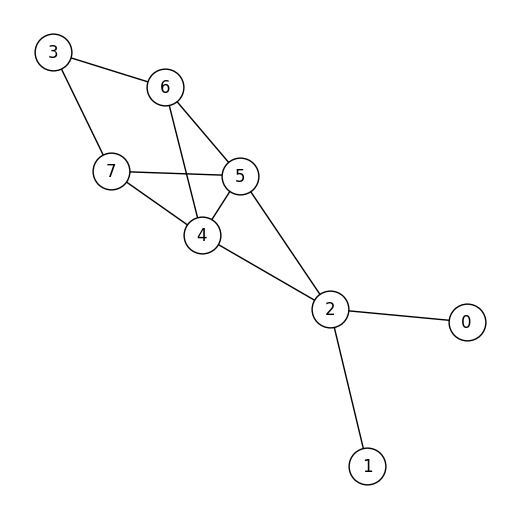

In [5]:
# パラメータ
# 頂点の数
num_nodes = 8  
# 辺を追加する確率
edge_probability = 0.5  

# ランダムグラフの生成
def generate_random_graph(num_nodes, edge_probability):
    G = nx.Graph()
    # ノードの追加
    for i in range(num_nodes):
        G.add_node(i)

    # ランダムに辺を追加
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if random.random() < edge_probability:
                G.add_edge(i, j)

    return G

G = generate_random_graph(num_nodes, edge_probability)

# 作成したランダムグラフの可視化
def plot_graph(G):
    pos = nx.spring_layout(G, seed=1)
    plt.figure(figsize=(5,5))
    nx.draw(G, pos, with_labels=True, node_color='white', node_size=700,
           edgecolors='black')
    plt.show()

plot_graph(G)

`JijModeling`で作成したモデルで使用できる形式で問題のデータを準備します。

In [6]:
inst_E = [list(edge) for edge in G.edges]
instance_data = {"V": num_nodes,"E": inst_E}
num_qubits = num_nodes

## コンパイル済みインスタンスの作成

コンパイル済みインスタンスとは、数式中の定数に実際の値が代入された中間表現のことです。さまざまなアルゴリズムへ変換する前に、まずこのコンパイル済みインスタンスを作成する必要があります。

In [7]:
intepreter = jm.Interpreter(instance_data)
compiled_instance = intepreter.eval_problem(problem)

## Qamomileを用いたQAOA回路とハミルトニアンの生成

`Qamomile`は、コンパイル済みインスタンスからQAOA用の回路とハミルトニアンを生成するためのコンバーターを提供しています。また、QUBOへの変換の過程で発生するパラメータを設定することも可能です。

まず、イジング形式のハミルトニアンを生成します。これが完了すると、QAOAの量子回路およびハミルトニアンも生成できます。

In [8]:
qaoa_converter = qm.qaoa.QAOAConverter(compiled_instance)

# イジング形式に変換
qaoa_converter.ising_encode()

# QAOA量子回路を取得
qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p=3) # pはレイヤー数

# コストハミルトニアンの取得
qaoa_hamiltonian = qaoa_converter.get_cost_hamiltonian()

## QAOA回路の可視化

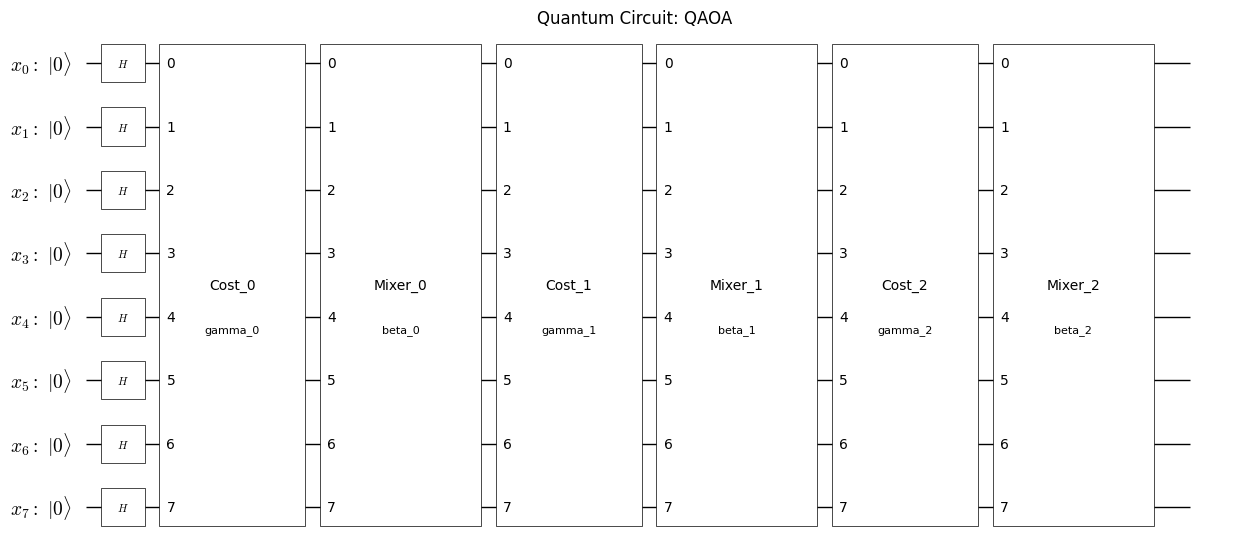

In [9]:
plot_quantum_circuit(qaoa_circuit)

## 取得したQAOA回路とハミルトニアンをQiskit向けに変換

`Qamomile`は、複数の量子アルゴリズムをサポートするために、独自の量子回路およびハミルトニアンの表現形式を持っています。これらは、目的の量子ライブラリで使用するためには変換が必要です。

このドキュメントの執筆時点（2024年12月4日）では、`Qamomile`がサポートしている量子ライブラリは以下の通りです：

- Qiskit  
- Quri-Parts  
- Qutip

ここでは、例としてまずQiskit用に量子回路とハミルトニアンを変換してみましょう。そのために、まず`QiskitTranspiler`のインスタンスを作成します。このクラスの`transpile_circuit`メソッドおよび`transpile_hamiltonian`メソッドを使用して、Qiskit形式の量子回路およびハミルトニアンを生成します。

In [10]:
qk_transpiler = qm_qk.QiskitTranspiler()

# 回路の作成
qk_circuit = qk_transpiler.transpile_circuit(qaoa_circuit)

# ハミルトニアンの作成
qk_hamiltonian = qk_transpiler.transpile_hamiltonian(qaoa_hamiltonian)
qk_hamiltonian

SparsePauliOp(['IIIIIIZZ', 'IIIIZIIZ', 'IIIZIIIZ', 'IIZIIIIZ', 'IZIIIIIZ', 'ZIIIIIIZ', 'IIIIZIZI', 'IIIZIIZI', 'IIZIIIZI', 'IZIIIIZI', 'ZIIIIIZI', 'IIIIZZII', 'IZIIIZII', 'ZIIIIZII', 'IIIZZIII', 'IIZIZIII', 'ZZIIIIII', 'IIIIIIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j, 7.5+0.j])

## QAOAの実行

すべての準備が整ったので、QAOAを実行してみましょう。ここでは、最適化アルゴリズムとしてScipyのCOBYLAを使用します。

In [11]:
cost_history = []
def cost_estimator(param_values):
    estimator = qk_pr.StatevectorEstimator()
    job = estimator.run([(qk_circuit, qk_hamiltonian, param_values)])
    result = job.result()[0]
    cost = result.data['evs']
    cost_history.append(cost)
    return cost

initial_params = [np.pi / 4, np.pi / 2, np.pi / 2, np.pi / 4,np.pi / 4, np.pi / 2]

# Run QAOA optimization
result = minimize(
    cost_estimator,
    initial_params,
    method="COBYLA",
    options={"maxiter": 1000},
)
print(result)

 message: Return from COBYLA because the objective function has been evaluated MAXFUN times.
 success: False
  status: 3
     fun: 4.988142917490432
       x: [ 1.137e+00  2.885e+00  3.160e+00  3.700e-01  7.622e-01
            2.449e+00]
    nfev: 1000
   maxcv: 0.0


## 結果の可視化
コスト関数の変化も見てみましょう。

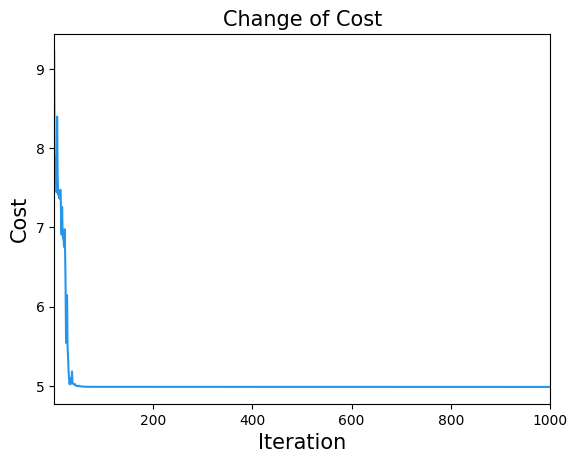

In [12]:
plt.title("Change of Cost", fontsize=15)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Cost", fontsize=15)
plt.xlim(1, result.nfev)
plt.plot(cost_history, label="Cost", color="#2696EB")
plt.show()

QAOAのパラメータが得られたので、それを使ってサンプリングを行いましょう。

In [13]:
# Run Optimized QAOA circuit
sampler = qk_pr.StatevectorSampler()
qk_circuit.measure_all()
job = sampler.run([(qk_circuit, result.x)], shots=1000)
job_result = job.result()[0]
qaoa_counts = job_result.data["meas"]

## 結果の評価  
解を評価するためには、`sample_set`を使うのが便利です。これを用いることで、得られた解から目的関数の値や制約違反などを計算することができます。

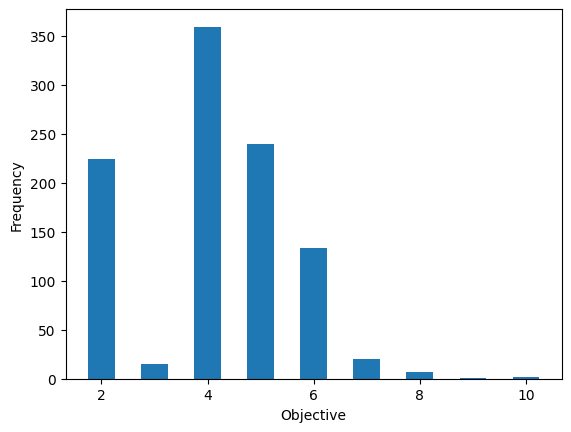

In [14]:
sampleset = qaoa_converter.decode(qk_transpiler, job_result.data["meas"])

# Initialize a dictionary to accumulate occurrences for each energy value
frequencies = defaultdict(int)

for sample_id in sampleset.sample_ids:
    sample = sampleset.get(sample_id)
    energy = round(sample.objective, ndigits=3)
    frequencies[energy] += 1

plt.bar(frequencies.keys(), frequencies.values(), width=0.5)
plt.xlabel('Objective')
plt.ylabel('Frequency')
plt.show()

## 解のプロット

目的関数の値は $V_1$ と $V_2$ を結ぶ辺の数を表しているため、最も小さい値を持つパターンが解と考えられます。それでは、得られた結果をグラフ上にプロットしてみましょう。

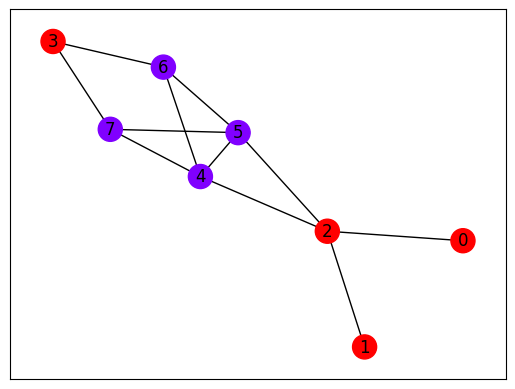

In [15]:
def plot_graph_coloring(graph: nx.Graph, sampleset: ommx.v1.SampleSet):
    # extract feasible solution
    best_sol = sampleset.best_feasible_unrelaxed

    pos = nx.spring_layout(graph,seed=1)
    x_value = best_sol.extract_decision_variables("x")
    color_map = []
    for node in graph.nodes:
        color_map.append(x_value[(node,)])

    # Draw the graph with the color mapping
    nx.draw_networkx(graph, pos, with_labels=True,
                     node_color=color_map, cmap=plt.get_cmap('rainbow'))

plot_graph_coloring(G, sampleset)

## Qamomileを使用したQuri-Partsへの変換
次に、Quri-Partsへの変換を行いましょう。Qiskitの場合と同様の手順で変換を行います。

In [16]:
quri_transpiler = QuriPartsTranspiler()
quri_circuit = quri_transpiler.transpile_circuit(qaoa_circuit)
quri_hamiltonian = quri_transpiler.transpile_hamiltonian(qaoa_hamiltonian)

これからパラメータを設定し、最適化を実行します。

In [17]:
cb_state = quantum_state(quri_circuit.qubit_count, bits=0)
parametric_state = apply_circuit(quri_circuit, cb_state)

Qulacsを使ったQuri-Partsは、Qiskitよりも高速に動作する量子回路シミュレータです。この優れた速度を活かして、実験の反復回数を増やしてみましょう。そうすることで、結果のさらなる改善が期待でき、Quri-Partsの能力をより深く探ることができます。コードを変更して反復回数を増やし、それがサンプリング結果や最小目的関数値の出現頻度にどのような影響を与えるかを確認しましょう。

In [18]:
estimator = create_qulacs_vector_parametric_estimator()

cost_history = []
def cost_fn(param_values: Sequence[float]) -> float:
    estimate = estimator(quri_hamiltonian, parametric_state, param_values)
    cost = estimate.value.real
    cost_history.append(cost)
    return cost

result = minimize(cost_fn, initial_params, method="COBYLA", options={"maxiter": 20000})
result

 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: 5.706278045417498
       x: [ 1.745e+00  1.597e+00  1.368e+00  1.231e+00  2.712e+00
            1.879e+00]
    nfev: 4168
   maxcv: 0.0

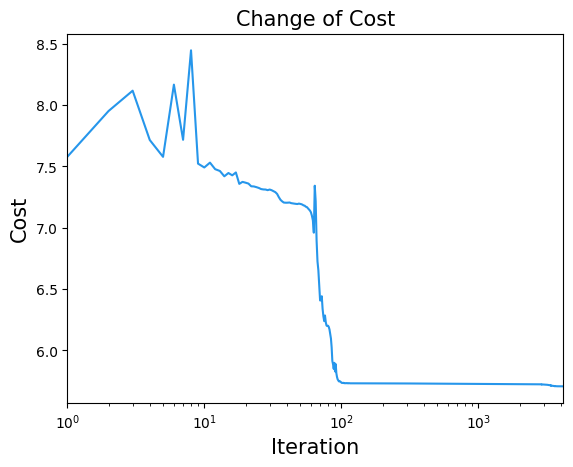

In [19]:
plt.title("Change of Cost", fontsize=15)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Cost", fontsize=15)
plt.xlim(1, result.nfev)
plt.xscale("log")
plt.plot(cost_history, label="Cost", color="#2696EB")
plt.show()

コスト関数が十分に減少したように見える場合、得られたパラメータを使用して解のサンプリングを行います。

In [20]:
sampler = create_qulacs_vector_sampler()
bounded_circuit = quri_circuit.bind_parameters(result.x)
qp_result = sampler(bounded_circuit, 1000)

サンプリング結果を可視化してみましょう。

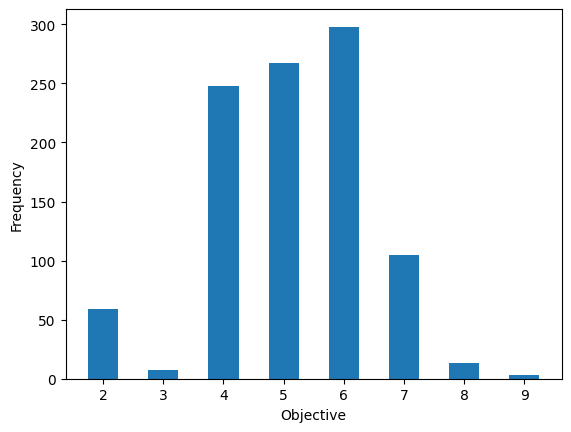

In [21]:
sampleset = qaoa_converter.decode(quri_transpiler, (qp_result, quri_circuit.qubit_count))

# Initialize a dictionary to accumulate occurrences for each energy value
frequencies = defaultdict(int)

for sample_id in sampleset.sample_ids:
    sample = sampleset.get(sample_id)
    energy = round(sample.objective, ndigits=3)
    frequencies[energy] += 1

plt.bar(frequencies.keys(), frequencies.values(), width=0.5)
plt.xlabel('Objective')
plt.ylabel('Frequency')
plt.show()

取得した結果をプロットしてみましょう。

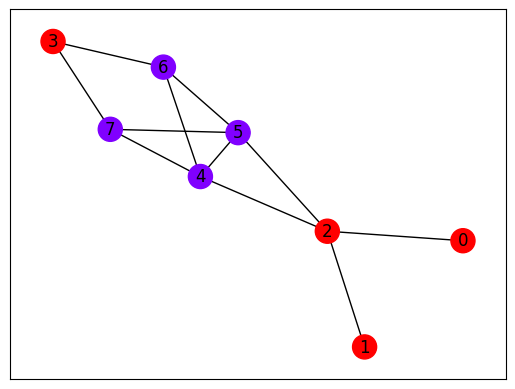

In [22]:
plot_graph_coloring(G, sampleset)